# Pós Tech Challenge FIAP - Fase 1

Este notebook apresenta o desenvolvimento de um modelo preditivo de regressão para estimar os custos médicos individuais cobrados pelo seguro de saúde, conforme desafio proposto na Fase 1 do Pós Tech da FIAP.

**Integrantes do grupo:**
- Carlos Adriano
- Daniel Kiluange
- Leonardo Nogueira

O passo a passo inclui:
- Carregamento e exploração dos dados
- Pré-processamento e tratamento de valores ausentes
- Conversão de variáveis categóricas
- Visualização exploratória
- Separação dos dados em treino e teste
- Treinamento do modelo de regressão linear
- Avaliação e visualização dos resultados

O objetivo é construir um modelo capaz de prever os encargos médicos a partir das características dos clientes, utilizando técnicas de aprendizado supervisionado.

In [54]:
import pandas as pd
import numpy as np

In [55]:
# Carregando o dataset
raw_dataset = pd.read_csv('seguro_saude_dataset_2.csv')

In [56]:
# Verificando se o dataset possui valores nulos e exibindo informações gerais
print(raw_dataset.info())
print(raw_dataset.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   idade     100000 non-null  int64  
 1   genero    100000 non-null  object 
 2   imc       100000 non-null  float64
 3   fumante   100000 non-null  object 
 4   regiao    100000 non-null  object 
 5   encargos  100000 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 4.6+ MB
None
idade       0
genero      0
imc         0
fumante     0
regiao      0
encargos    0
dtype: int64


In [57]:
num_dataset = raw_dataset.copy()

In [58]:
# Substituindo os valores binários de 'genero' e 'fumante' por 0 e 1 e separando a coluna 'regiao' em novas colunas binárias

num_dataset['regiao'] = (
    num_dataset['regiao'].map({'norte': 1, 'nordeste': 2, 'centro-oeste': 3, 'sudeste': 4, 'sul': 5}))

In [59]:
num_dataset['genero'] = num_dataset['genero'].map({'masculino': 0, 'feminino': 1})
num_dataset['fumante'] = num_dataset['fumante'].map({'não': 0, 'sim': 1})
num_dataset.head()

,idade,genero,imc,fumante,regiao,encargos
0,56,0,24.54,0,4,9816.22
1,69,0,18.24,1,2,21870.06
2,46,1,26.23,0,1,6969.30
3,32,0,19.08,0,4,6603.50
4,60,0,25.64,0,4,8780.76


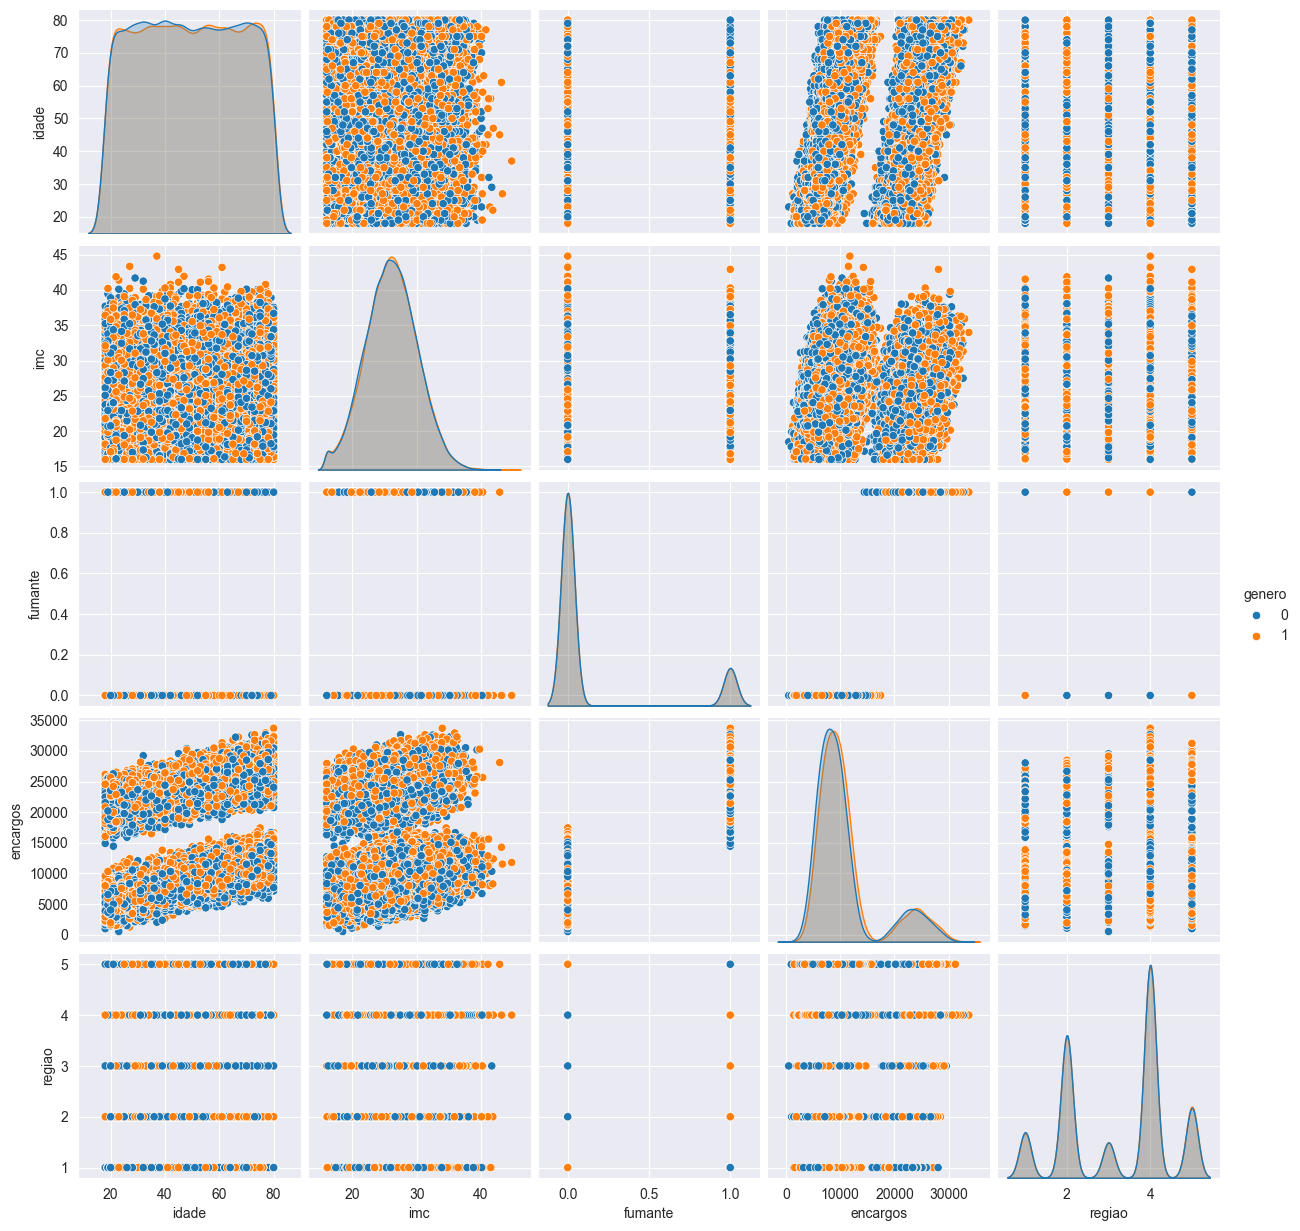

In [19]:
import seaborn as sns

#Exibindo gráficos de dispersão geral do dataset separados por gênero
sns.pairplot(data=num_dataset, hue='genero', vars=['idade', 'imc', 'fumante', 'encargos', 'regiao'])

In [60]:
X = num_dataset[['idade', 'imc', 'genero', 'fumante', 'regiao']]
y = num_dataset['encargos']

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [62]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

# Create preprocessing steps
numeric_features = ['idade', 'imc']
categorical_features = ['genero', 'fumante', 'regiao']


# Define custom scaling functions with weights
def weighted_numeric_scaler(weight):
    def scaler(X):
        return StandardScaler().fit_transform(X) * weight

    return FunctionTransformer(scaler)


def weighted_categorical_scaler(weight):
    def scaler(X):
        return OneHotEncoder(drop='first', sparse_output=False).fit_transform(X) * weight

    return FunctionTransformer(scaler)

In [178]:
from sklearn.pipeline import make_pipeline

weighted_preprocessor = ColumnTransformer(
    transformers=[
        # Adjust these weights based on your needs
        ('num', make_pipeline(
            StandardScaler(),
            FunctionTransformer(lambda x: x * 0.7)  # Numeric features weight
        ), numeric_features),
        ('cat', make_pipeline(
            OneHotEncoder(drop='first', sparse_output=False),
            FunctionTransformer(lambda x: x * 0.3)  # Categorical features weight
        ), categorical_features)
    ])


In [179]:

# create a pipeline object
pipeline = Pipeline([
    ('preprocessor', weighted_preprocessor),
    ('regressor', Lasso(0.1))
])


In [ ]:
from sklearn.metrics import r2_score

r2_train_scores = []
r2_test_scores = []

for i in range(10_000):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    pipeline.fit(X_train, y_train)
    train_predictions = pipeline.predict(X_train)
    test_predictions = pipeline.predict(X_test)

    r2_train = r2_score(y_train, train_predictions)
    r2_test = r2_score(y_test, test_predictions)

    r2_train_scores.append(r2_train)
    r2_test_scores.append(r2_test)

# Calculate average performance
print(f"Average Train R² Score: {np.mean(r2_train_scores):.4f} ± {np.std(r2_train_scores):.4f}")
print(f"Average Test R² Score: {np.mean(r2_test_scores):.4f} ± {np.std(r2_test_scores):.4f}")





In [188]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error


def evaluate_model(y_true, y_pred):
    metrics = {
        'R²': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }
    return metrics


In [189]:
# Calculate and display model performance metrics
train_predictions = pipeline.predict(X_train)
test_predictions = pipeline.predict(X_test)

In [190]:
print("Training Set Metrics:")
train_metrics = evaluate_model(y_train, train_predictions)
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")


Training Set Metrics:
R²: 0.9657
MAE: 885.7601
RMSE: 1113.1319
MAPE: 10.0331


In [191]:
print("\nTest Set Metrics:")
test_metrics = evaluate_model(y_test, test_predictions)
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")



Test Set Metrics:
R²: 0.9657
MAE: 885.6052
RMSE: 1116.7721
MAPE: 10.1530


In [192]:
import matplotlib.pyplot as plt

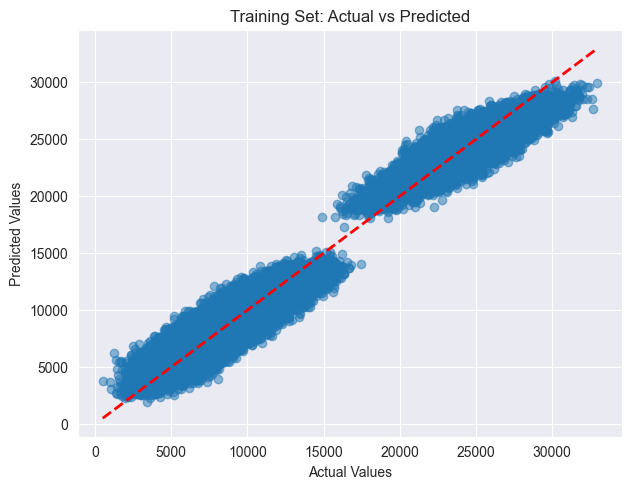

In [186]:
# Training set
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_train, train_predictions, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Training Set: Actual vs Predicted')
plt.tight_layout()
plt.show()


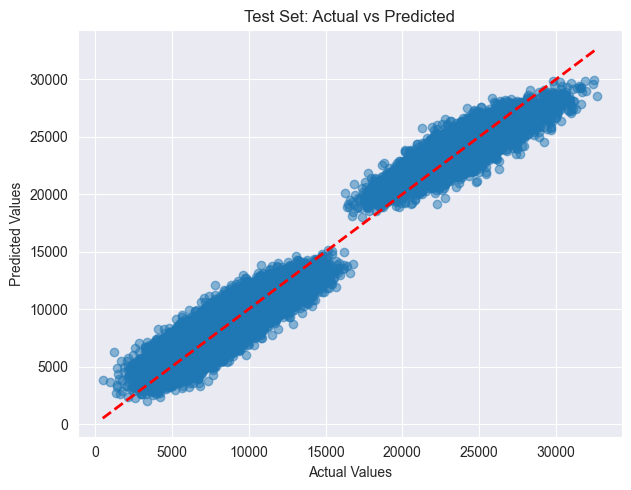

In [193]:
# Test set
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Test Set: Actual vs Predicted')
plt.tight_layout()
plt.show()


In [194]:
# Calculate residuals and plot them
residuals_train = y_train - train_predictions
residuals_test = y_test - test_predictions

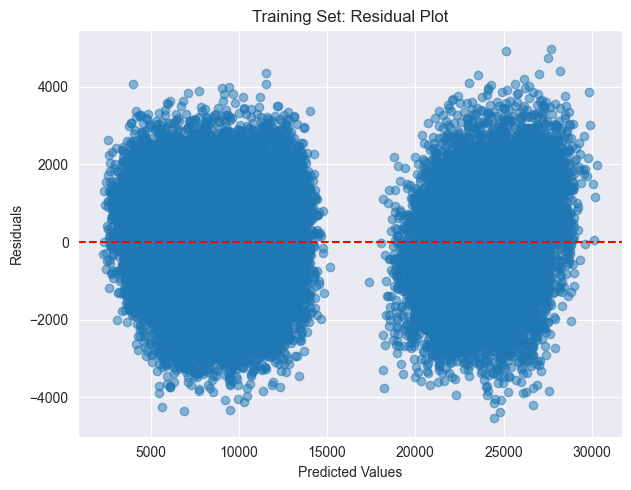

In [195]:
# Training set residuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(train_predictions, residuals_train, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Training Set: Residual Plot')
plt.tight_layout()
plt.show()


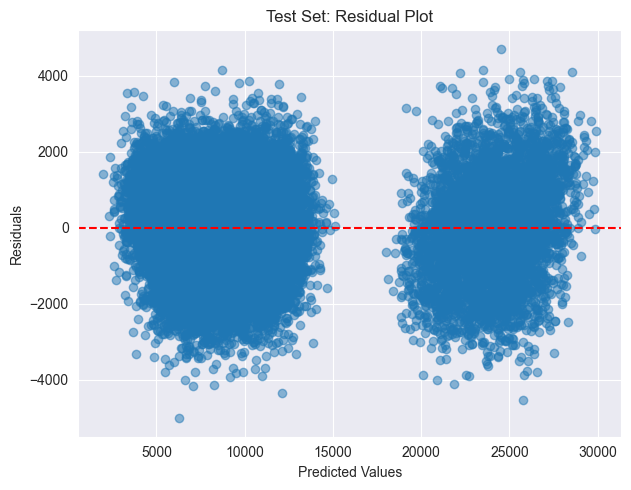

In [196]:
# Test set residuals
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.scatter(test_predictions, residuals_test, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Test Set: Residual Plot')
plt.tight_layout()
plt.show()


In [197]:
column_name = ['idade', 'genero', 'imc', 'fumante', 'regiao']
predict_data = [[56, 0, 24.54, 0, 4]]
predict_data_df = pd.DataFrame(predict_data, columns=column_name)




In [95]:
pipeline.predict(predict_data_df)

array([9518.70818381])